# Border Analysis with GradCAM

This notebook shows how we computed the border activations of the networks using GradCAM. All GradCAM visualizations presented in our paper can be reconstructed using the following code.

## Set up environment

In [30]:
#install modules if needed
!python -c "import torch" || pip install -q torch torchvision
!python -c "import monai" || pip install -q "monai[nibabel, einops, matplotlib]"
!python -c "import pytorch_grad_cam" || pip install -q grad-cam


#imports
import os
import glob
import torch
import numpy as np
import matplotlib.pyplot as plt

from monai.networks.nets import UNETR, AttentionUnet, UNet
from monai.data.dataset import Dataset
from monai.data.dataloader import DataLoader
from monai.transforms import LoadImaged, Transposed, EnsureChannelFirstd, Resized, ToTensord, AsDiscrete, Compose

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import SemanticSegmentationTarget

## Initialize data

This section uses an example ultrasound image. You can choose between the two anatomical structures presented in the paper: thyroid and leg. 
If you want to use your own data, change the code according to your needs. Note that not the full datasets are provided due to file size. 

In [32]:
anatomical_structure = "leg" #choose between two alternatives: "leg" and "thyroid"

transforms = Compose([
    LoadImaged(keys=("img", "label", "completed", "distinct"), image_only=True),
    Transposed(keys=("img", "label", "completed", "distinct"), indices=(2,1,0)),
    EnsureChannelFirstd(keys=("img", "label", "completed", "distinct")),
    Resized(keys=("img", "label", "completed", "distinct"), spatial_size=(96,96,96), mode=("trilinear", "nearest", "nearest", "nearest"), align_corners=(False, None, None, None)),
    ToTensord(keys=("img", "label", "completed", "distinct")),
])

#adapt according to your data structure
data_path = os.path.join("./", "data", anatomical_structure)
imgs = glob.glob(os.path.join(data_path, "*.nii*"))
full_labels = glob.glob(os.path.join(data_path, "labels", "full*.nii*"))
completed_border_labels = glob.glob(os.path.join(data_path, "labels", "completed*.nii*"))
distinct_border_labels = glob.glob(os.path.join(data_path, "labels", "distinct*.nii*"))

files = [{"img": img_path, "label": label_path, "completed": completed_path, "distinct": distinct_path} \
    for (img_path, label_path, completed_path, distinct_path) in zip(imgs, full_labels, completed_border_labels, distinct_border_labels)]

#files = [{"img": img_path, "label": label_path} for (img_path, label_path) in zip(imgs, full_labels)]


dataset = Dataset(files, transforms)
dataloader = DataLoader(dataset)

## Load model

This section uses the pretrained models provided in this repository. You can choose between the three network architectures presented in the paper: UNet (unet), Attention UNet (uneta) and UNet Transformer (unetr). If you want to use your own pretrained model, change the code according to your needs.

In [33]:
model_architecture = "unet" #choose between 3 alternatives: unet, uneta or unetr

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if model_architecture == "unet":
    model = UNet(
            spatial_dims=3,
            in_channels=1, 
            out_channels=4,  #number of segmentation classes
            channels=(8, 16, 16, 32, 32, 64, 64),  
            strides=(1, 2, 1, 2, 1, 2),  
            dropout=0.2,
            norm="batch",
        )

elif model_architecture == "uneta":
    model = AttentionUnet(
            spatial_dims=3,  
            in_channels=1,  
            out_channels=4,  #number of segmentation classes
            channels=(8, 16, 32, 64),
            strides=(2, 2, 2),
            dropout=0.2,
        )

elif model_architecture == "unetr":
    model = UNETR(
            spatial_dims=3,
            in_channels=1,  
            out_channels=4,  #number of segmentation classes
            img_size=(96,96,96),  #same as spatial_size of resize transform
            norm_name="batch",
        )

else:
    raise NotImplementedError(f"This model architecture is not implemented: {model_architecture}")


model.load_state_dict(torch.load(os.path.join("weights", anatomical_structure, f"{model_architecture}.pth"), map_location=device))
model.eval()

UNet(
  (model): Sequential(
    (0): Convolution(
      (conv): Conv3d(1, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (adn): ADN(
        (N): BatchNorm3d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (D): Dropout(p=0.2, inplace=False)
        (A): PReLU(num_parameters=1)
      )
    )
    (1): SkipConnection(
      (submodule): Sequential(
        (0): Convolution(
          (conv): Conv3d(8, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
          (adn): ADN(
            (N): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (D): Dropout(p=0.2, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
        (1): SkipConnection(
          (submodule): Sequential(
            (0): Convolution(
              (conv): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
              (adn): ADN(
                (N): BatchNorm3d(16, e

## Initialize GradCAM

The target layer for the GradCAM computation is the network's output layer. If you want to use your own pretrained network, adapt the code accordingly.

In [34]:
#Choose target layer depending on the network
if model_architecture == "unet" or model_architecture == "uneta":
    target_layers=[model.model]
elif model_architecture == "unetr":
    target_layers=[model.decoder2]
else:
    raise NotImplementedError(f"No target layer specified for this model architecture: {model_architecture}")

cam = GradCAM(model=model, target_layers=target_layers)

## Compute GradCAM for general border activation

Our analyzation found that in Ultrasound Images, the networks get activated in the border areas when segmenting the background. Therefore, to visualize the border activations, we apply GradCAM using the background as target. This means using the background class of the prediction (0) as category and a one-hot encoded label for the background (the background is marked with 1, everything else with 0) in the SemanticSegmentationTarget.

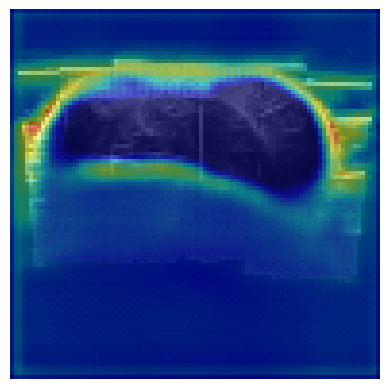

In [35]:
for batch in dataloader:
    img = batch["img"].to(device)
    label = batch["label"].to(device)

    #retrieve background label, SemanticSegmentationTarget expects numpy array
    cam_label = AsDiscrete(to_onehot=4)(label[0])[0].detach().numpy() #shape: (96,96,96) 

    #initialize background target
    background_target = SemanticSegmentationTarget(category=0, mask=cam_label)
    
    #compute gradcam
    gradcam = np.squeeze(cam(input_tensor=img, targets=[background_target])) #shape: (96,96,96), values: 0 to 1

    #prepare image and gradcam for plotting in 2D
    slice = 45 
    rotation = 1 if anatomical_structure == "thyroid" else -1 #for accurate orientation
    plot_img = torch.rot90((torch.squeeze(img).permute(2,1,0))[:,:, slice], rotation)
    plot_gradcam = np.rot90(np.transpose(gradcam)[:,:, slice], rotation)

    #visualize gradcam in a middle slice
    plt.figure()
    plt.imshow(plot_img, cmap="gray")
    plt.imshow(plot_gradcam, cmap="jet", alpha=0.5, vmin=0, vmax=1)
    plt.axis("off")
    plt.show()

## Compute GradCAM to analyze activations for distinct and completed borders

To evaluate the network's activations during segmentation of distinct and completed borders, we still have to evaluate the background category (0) as it shows the border activations. However, the label used in the GradCAM computation is not a label of the background, but the labels for distinct and completed borders respectively. Those labels have to be created beforehand, this repository includes one example each for the thyroid and the leg datasets.

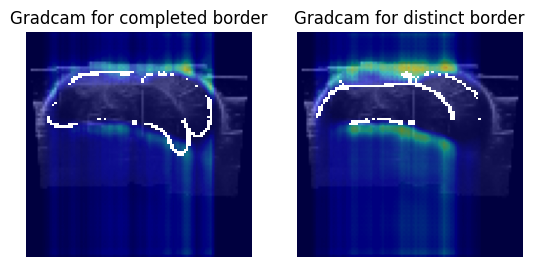

In [36]:
for batch in dataloader:
    img = batch["img"].to(device) #shape (1,1,96,96,96)
    completed_label = torch.squeeze(batch["completed"].to(device)) #shape (96,96,96)
    distinct_label = torch.squeeze(batch["distinct"].to(device)) #shape (96,96,96)

    #initialize background target for both labels
    target_completed = SemanticSegmentationTarget(category=0, mask=completed_label.detach().numpy())
    target_distinct = SemanticSegmentationTarget(category=0, mask=distinct_label.detach().numpy())

    #compute gradcam for both labels
    gradcam_completed = np.squeeze(cam(input_tensor=img, targets=[target_completed])) #shape: (96,96,96), values: 0 to 1
    gradcam_distinct = np.squeeze(cam(input_tensor=img, targets=[target_distinct])) #shape: (96,96,96), values: 0 to 1

    #prepare image, gradcams and border labels for plotting in 2D
    slice = 45 
    rotation = 1 if anatomical_structure == "thyroid" else -1 #for accurate orientation
    plot_img = torch.rot90((torch.squeeze(img).permute(2,1,0))[:,:, slice], rotation)
    plot_completed_cam = np.rot90(np.transpose(gradcam_completed)[:,:, slice], rotation)
    plot_distinct_cam = np.rot90(np.transpose(gradcam_distinct)[:,:, slice], rotation)
    plot_completed_label = torch.where(completed_label != 0, completed_label, torch.nan) #make background transparent
    plot_completed_label = torch.rot90((torch.squeeze(plot_completed_label).permute(2,1,0))[:,:, slice], rotation)
    plot_distinct_label = torch.where(distinct_label != 0, distinct_label, torch.nan) #make background transparent
    plot_distinct_label = torch.rot90((torch.squeeze(plot_distinct_label).permute(2,1,0))[:,:, slice], rotation)    

    #visualize gradcam
    plt.figure()
    plt.subplot(1,2,1)
    plt.title("Gradcam for completed border")
    plt.axis("off")
    plt.imshow(plot_img, cmap="gray")
    plt.imshow(plot_completed_cam, cmap="jet", alpha=0.5, vmin=0, vmax=1)
    plt.imshow(plot_completed_label, cmap="binary", interpolation='none')
    plt.subplot(1,2,2)
    plt.title("Gradcam for distinct border")
    plt.axis("off")
    plt.imshow(plot_img, cmap="gray")
    plt.imshow(plot_distinct_cam, cmap="jet", alpha=0.5, vmin=0, vmax=1)
    plt.imshow(np.where(plot_distinct_label != 0, plot_distinct_label, np.nan), cmap="binary", interpolation="none")
    plt.show()